In [1]:
%matplotlib inline
# useful additional packages 

#import math tools
import numpy as np
import scipy.linalg as linalg

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.quantum_info import Operator
from qiskit.compiler import transpile
from qiskit.providers.aer import noise

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram, plot_gate_map, plot_circuit_layout

import kmeans_qaoa as kq

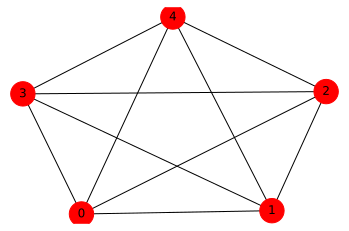

In [2]:
# Generate a complete, weighted graph with 5 nodes
n = 5
G = nx.complete_graph(n)
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=False)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

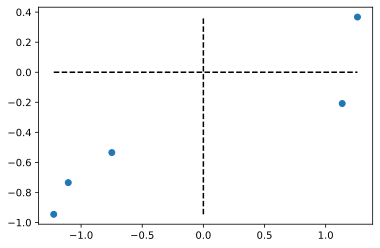

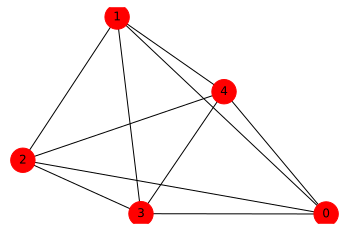

In [3]:
coreset_points, G = kq.gen_coreset_graph()
kq.plot_coreset_graph(coreset_points, G)

OrderedDict([('cx', 20), ('rz', 10), ('h', 5), ('rx', 5), ('measure', 5), ('barrier', 3)])


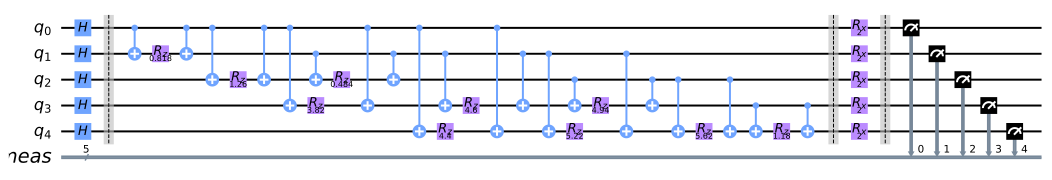

In [5]:
mycirc = kq.gen_complete_qaoa_circ(1, [1], [1], G)
print(mycirc.count_ops())
mycirc.draw(output='mpl', scale=0.4, fold=180)

OrderedDict([('u1', 20), ('cu1', 10), ('h', 5), ('rx', 5), ('measure', 5), ('barrier', 3)])


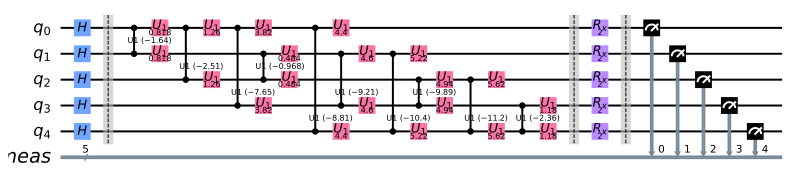

In [6]:
mycirc = kq.gen_complete_qaoa_circ(1, [1], [1], G, ising=True)
print(mycirc.count_ops())
mycirc.draw(output='mpl', scale=0.4, fold=180)

# Run QAOA on QASM simulator

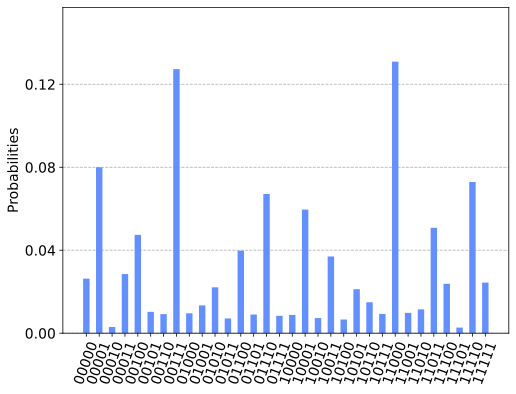

In [7]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")
shots = 10000

simulate = execute(mycirc, backend=backend, shots=shots)
QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- SIMULATION RESULTS ---

The approximate solution is x* = 11100 with C(x*) = 14 

The cost function is distributed as: 



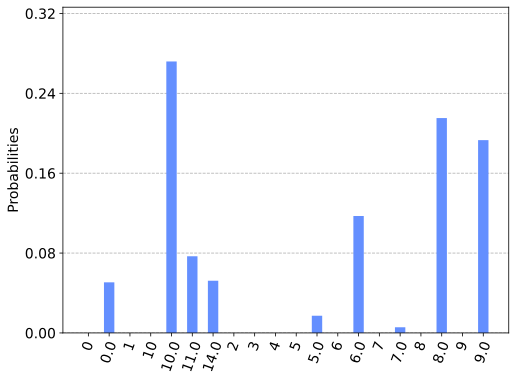

In [8]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = kq.cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
#print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

# Energy Landscape

In [171]:
# Use the circuit generator to estimate the energy landscape
step_size=0.05
P = 1
backend = Aer.get_backend("qasm_simulator")
shots = 10000

a_gamma = np.arange(0, np.pi, step_size)
a_beta  = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma, a_beta)

estC = []
max_C = [0,-np.inf]
best_angles = [0,0]
for gamma_list, beta_list in zip(a_gamma, a_beta):
    C_row = []
    for gamma, beta in zip(gamma_list, beta_list):
        qaoa_circ = gen_qaoa_circ(P, [gamma], [beta], G)

        simulate = execute(qaoa_circ, backend=backend, shots=shots)
        QAOA_results = simulate.result()
        
        # Evaluate the data from the simulator
        counts = QAOA_results.get_counts()

        avr_C = 0
        hist  = {}

        for k in range(len(G.edges())+1):
            hist[str(k)] = hist.get(str(k),0)

        for sample in list(counts.keys()):
            # use sampled bit string x to compute C(x)
            x = [int(num) for num in list(sample)]
            tmp_eng = cost_function_C(x,G)
    
            # compute the expectation value and energy distribution
            avr_C = avr_C + counts[sample]*tmp_eng
            hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
            
            # save best bit string
            if(max_C[1] < tmp_eng):
                max_C[0] = sample
                max_C[1] = tmp_eng
                best_angles = [gamma, beta]
                
        M1_sampled   = avr_C/shots
        
        C_row.append(M1_sampled)
    estC.append(C_row)
estC = np.array(estC)

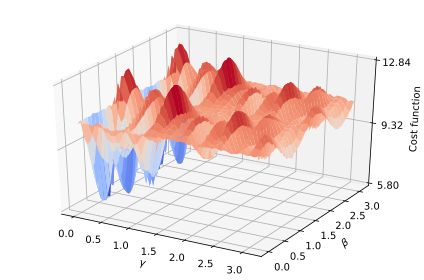


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value (avg over 10000 shots) is:  M1 = 12.837
This is attained for gamma = 0.700 and beta = 1.300
Best single partitioning and cost achieved were: 00011, C = 18.180
With parameters: gamma = 0.000 and beta = 0.000
mu_plus: [1.441 0.926]
mu_minus: [-0.865 -0.911]


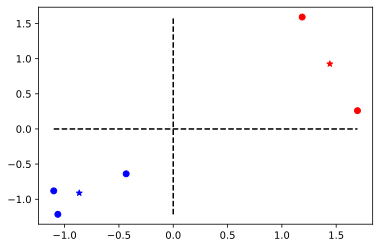

In [172]:
# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, estC, cmap=cm.coolwarm, linewidth=0, antialiased=True)

#ax.set_zlim(1,4)
#ax.set_xlim(3,6)
#ax.set_ylim(3,6)
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel('Cost function')
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.tight_layout()
plt.show()
plt.close()

result = np.where(estC == np.amax(estC))
a = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value (avg over {} shots) is:  M1 = {:.3f}'.format(shots, np.amax(estC)))
print('This is attained for gamma = {0:.3f} and beta = {1:.3f}'.format(gamma,beta))
print('Best single partitioning and cost achieved were: {}, C = {:.3f}'.format(max_C[0], max_C[1]))
print('With parameters: gamma = {0:.3f} and beta = {1:.3f}'.format(best_angles[0], best_angles[1]))

# Plot the centroids according to the optimal partitioning
c_plus = 'red'
c_minus = 'blue'

S_plus = [coreset_points[i] for i in range(len(max_C[0])) if max_C[0][i] == '1']
xx_plus = [pt[1][0] for pt in S_plus]
yy_plus = [pt[1][1] for pt in S_plus]
plt.scatter(xx_plus, yy_plus, c=c_plus)

S_minus = [coreset_points[i] for i in range(len(max_C[0])) if max_C[0][i] == '0']
xx_minus = [pt[1][0] for pt in S_minus]
yy_minus = [pt[1][1] for pt in S_minus]
plt.scatter(xx_minus, yy_minus, c=c_minus)

mu_plus = np.sum([point[0]*point[1] for point in S_plus], axis=0) / np.sum([point[0] for point in S_plus])
mu_minus = np.sum([point[0]*point[1] for point in S_minus], axis=0) / np.sum([point[0] for point in S_minus])
print('mu_plus:',mu_plus)
print('mu_minus:',mu_minus)
plt.scatter(mu_plus[0], mu_plus[1], c=c_plus, marker='*')
plt.scatter(mu_minus[0], mu_minus[1], c=c_minus, marker='*')

plt.hlines(0, np.amin(xx), np.amax(xx), ls='--')
plt.vlines(0, np.amin(yy), np.amax(yy), ls='--')
plt.show()
plt.close()

In [82]:
# Use the circuit generator to estimate the energy landscape
step_size=0.001
P = 1
backend = Aer.get_backend("qasm_simulator")
shots = 10000

a_gamma = np.arange(1.8, 1.9, step_size)
a_beta  = np.arange(0.15, 0.25, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma, a_beta)

estC = []
for gamma_list, beta_list in zip(a_gamma, a_beta):
    C_row = []
    for gamma, beta in zip(gamma_list, beta_list):
        qaoa_circ = gen_qaoa_circ(P, [gamma], [beta], G)

        simulate = execute(qaoa_circ, backend=backend, shots=shots)
        QAOA_results = simulate.result()
        
        # Evaluate the data from the simulator
        counts = QAOA_results.get_counts()

        avr_C = 0
        hist  = {}

        for k in range(len(G.edges())+1):
            hist[str(k)] = hist.get(str(k),0)

        for sample in list(counts.keys()):
            # use sampled bit string x to compute C(x)
            x = [int(num) for num in list(sample)]
            tmp_eng = cost_function_C(x,G)
    
            # compute the expectation value and energy distribution
            avr_C = avr_C + counts[sample]*tmp_eng
            hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
                
        M1_sampled   = avr_C/shots
        C_row.append(M1_sampled)
    estC.append(C_row)
estC = np.array(estC)

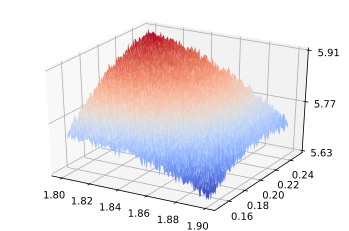

(array([97]), array([0]))
(97, 0)

 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 5.914
This is attained for gamma = 0.097 and beta = 0.000


In [83]:
# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, estC, cmap=cm.coolwarm, linewidth=0, antialiased=True)

#ax.set_zlim(1,4)
#ax.set_xlim(3,6)
#ax.set_ylim(3,6)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

result = np.where(estC == np.amax(estC))
print(result)
a = list(zip(result[0],result[1]))[0]
print(a)

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = {:.03f}'.format(np.amax(estC)))
print('This is attained for gamma = {0:.3f} and beta = {1:.3f}'.format(gamma,beta))

# Map to device

In [9]:
provider = IBMQ.load_account()

In [10]:
backends = provider.backends()
for b in backends: print(b)

ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_vigo
ibmq_ourense
ibmq_london
ibmq_burlington
ibmq_essex
ibmq_armonk
ibmq_rome


In [11]:
for backend in backends:
    print(backend.name())
    config = backend.configuration()
    #print(backend.status())
    print(config.n_qubits, config.simulator, config.open_pulse, config.memory)
    #print(config.coupling_map)
    cmap = nx.Graph()
    if config.coupling_map is not None:
        cmap.add_edges_from(config.coupling_map)
        #nx.draw(cmap)
        #plt.show()

ibmq_qasm_simulator
32 True False True
ibmqx2
5 False False True
ibmq_16_melbourne
15 False False True
ibmq_vigo
5 False False True
ibmq_ourense
5 False False True
ibmq_london
5 False False True
ibmq_burlington
5 False False True
ibmq_essex
5 False False True
ibmq_armonk
1 False True True
ibmq_rome
5 False False True


## IBMQ Rome

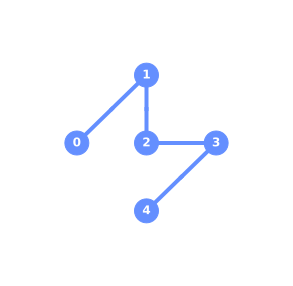

In [12]:
rome = provider.get_backend('ibmq_rome')
qasm_simulator = provider.get_backend('ibmq_qasm_simulator')
plot_gate_map(rome)

### Compile the cnot circuit to Rome

In [13]:
top = rome.configuration().coupling_map
print(top)

[[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]


[(0, 1), (2, 3)]
[(1, 2), (3, 4)]
cur cover: [(0, 1), (2, 3)]
cur cover: [(1, 2), (3, 4)]
cur cover: [(0, 1), (2, 3)]
cur cover: [(1, 2), (3, 4)]
cur cover: [(0, 1), (2, 3)]
Depth: 22
Gates: OrderedDict([('cx', 28), ('rz', 10), ('h', 5), ('rx', 5), ('measure', 5), ('barrier', 3)])
initial_layout = [0 1 2 3 4]


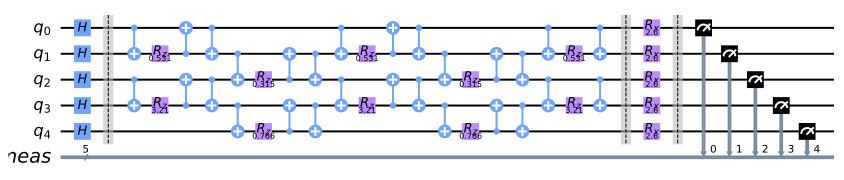

In [17]:
P, gamma, beta = 1, 0.65, 1.3
cnot_circ, initial_layout = kq.gen_complete_qaoa_circ(P, [gamma], [beta], G, ising=False, topology=rome.configuration().coupling_map)
print('Depth:', cnot_circ.depth())
print('Gates:', cnot_circ.count_ops())
print('initial_layout =', initial_layout)
cnot_circ.draw(output='mpl', fold=200, scale=0.4)

         ┌──────────┐ ░                     ┌───┐                                                       ┌───┐                                                             ░ ┌────────────────────┐ ░ »
q_0 -> 0 ┤ U2(0,pi) ├─░───■─────────────────┤ X ├──■──────────────────────────────────■─────────────────┤ X ├──■──────────────────────────────────■───────────────────■───░─┤ U3(2.6,-pi/2,pi/2) ├─░─»
         ├──────────┤ ░ ┌─┴─┐┌─────────────┐└─┬─┘┌─┴─┐                    ┌───┐     ┌─┴─┐┌─────────────┐└─┬─┘┌─┴─┐                    ┌───┐     ┌─┴─┐┌─────────────┐┌─┴─┐ ░ ├────────────────────┤ ░ »
q_1 -> 1 ┤ U2(0,pi) ├─░─┤ X ├┤ U1(0.53147) ├──■──┤ X ├──■─────────────────┤ X ├──■──┤ X ├┤ U1(0.53147) ├──■──┤ X ├──■─────────────────┤ X ├──■──┤ X ├┤ U1(0.53147) ├┤ X ├─░─┤ U3(2.6,-pi/2,pi/2) ├─░─»
         ├──────────┤ ░ └───┘└─────────────┘┌───┐└───┘┌─┴─┐ ┌────────────┐└─┬─┘┌─┴─┐└───┘└─────────────┘┌───┐└───┘┌─┴─┐ ┌────────────┐└─┬─┘┌─┴─┐└───┘└─────────────┘└───┘ ░ ├────────────────────┤ ░ »
q_2 -

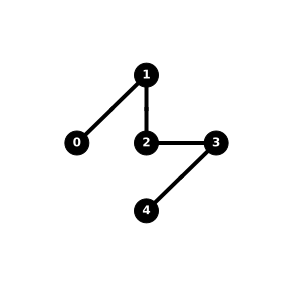

In [18]:
rome_cnots = transpile(cnot_circ, rome, optimization_level=1, initial_layout=initial_layout)
print(rome_cnots.draw(output='text', fold=200))
print('Depth:', rome_cnots.depth())
print('Gates:', rome_cnots.count_ops())
plot_circuit_layout(rome_cnots, rome)

### Compile the ising circuit to Rome

        ┌───┐ ░           ┌────────────┐          ┌────────────┐               ┌────────────┐                                  ┌────────────┐                                                     »
   q_0: ┤ H ├─░──■────────┤ U1(1.7765) ├─■────────┤ U1(0.6082) ├─■─────────────┤ U1(5.3413) ├────────────────────■─────────────┤ U1(7.8375) ├─────────────────────────────────────────────────────»
        ├───┤ ░  │-3.5529 ├────────────┤ │        └────────────┘ │             └────────────┘     ┌────────────┐ │             └────────────┘     ┌────────────┐               ┌────────────┐     »
   q_1: ┤ H ├─░──■────────┤ U1(1.7765) ├─┼───────────────────────┼─────────■──────────────────────┤ U1(1.8029) ├─┼─────────■──────────────────────┤ U1(5.8437) ├─■─────────────┤ U1(8.8571) ├─────»
        ├───┤ ░           └────────────┘ │-1.2164 ┌────────────┐ │         │-3.605-3.605-3.6057   ├────────────┤ │         │                      └────────────┘ │             └────────────┘     »
   q_2: ┤ H ├─░─────

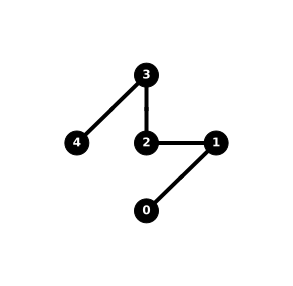

In [151]:
P, gamma, beta = 1, 1, 1
ising_circ = gen_qaoa_circ(P, [gamma], [beta], G, ising=True)
print(ising_circ.draw(output='text', fold=200))
print('Depth:', ising_circ.depth())
print('Gates:', ising_circ.count_ops())
rome_ising = transpile(ising_circ, rome, optimization_level=2)
print(rome_ising.draw(output='text', fold=200))
print('Depth:', rome_ising.depth())
print('Gates:', rome_ising.count_ops())
plot_circuit_layout(rome_ising, rome)

It looks like the Ising and CNOT circuits compile to the same circuit anyways....

### Run on device

In [24]:
def plot_partition(bitstring, coreset_points):
    c_plus = 'blue'
    c_minus = 'red'
    
    xx = [cp[1][0] for cp in coreset_points]
    yy = [cp[1][1] for cp in coreset_points]
    
    S_plus = [coreset_points[i] for i in range(len(bitstring)) if bitstring[i] == '1']
    xx_plus = [pt[1][0] for pt in S_plus]
    yy_plus = [pt[1][1] for pt in S_plus]
    plt.scatter(xx_plus, yy_plus, c=c_plus)
    
    S_minus = [coreset_points[i] for i in range(len(bitstring)) if bitstring[i] == '0']
    xx_minus = [pt[1][0] for pt in S_minus]
    yy_minus = [pt[1][1] for pt in S_minus]
    plt.scatter(xx_minus, yy_minus, c=c_minus)
    
    mu_plus = np.sum([point[0]*point[1] for point in S_plus], axis=0) / np.sum([point[0] for point in S_plus])
    mu_minus = np.sum([point[0]*point[1] for point in S_minus], axis=0) / np.sum([point[0] for point in S_minus])
    print('mu_plus:',mu_plus)
    print('mu_minus:',mu_minus)
    plt.scatter(mu_plus[0], mu_plus[1], c=c_plus, marker='*')
    plt.scatter(mu_minus[0], mu_minus[1], c=c_minus, marker='*')
    
    plt.hlines(0, np.amin(xx), np.amax(xx), ls='--')
    plt.vlines(0, np.amin(yy), np.amax(yy), ls='--')
    plt.show()
    plt.close()

In [20]:
# simulator
shots = 8192
noise_model = noise.device.basic_device_noise_model(rome.properties())
basis_gates = rome.configuration().basis_gates
rome_result = execute(rome_cnots, qasm_simulator, basis_gates=basis_gates, shots=shots, noise_model=noise_model,
                      coupling_map=rome.configuration().coupling_map, backend_properties=rome.properties()).result()
exact_results = execute(rome_cnots, qasm_simulator, shots=shots).result()

/Users/teague/ResearchWorkspace/coresets/coresetEnv/lib/python3.7/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


mu_plus: [ 0.01832629 -0.28910045]
mu_minus: [-0.23935414 -0.4925016 ]


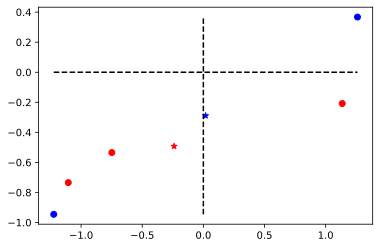

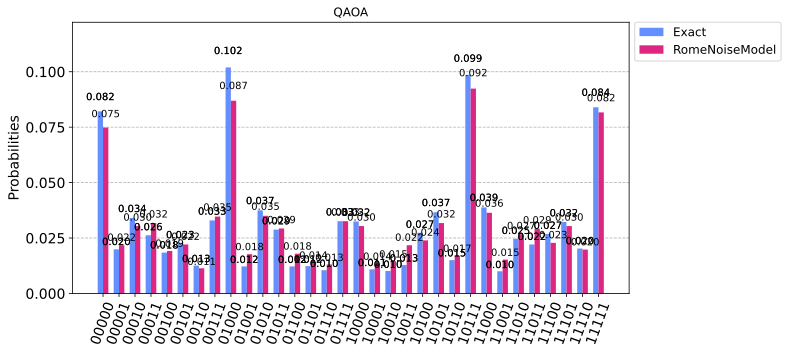

In [25]:
rome_counts = rome_result.get_counts(rome_cnots)
exact_counts = exact_results.get_counts(rome_cnots)

plot_partition('00101', coreset_points)
plot_histogram([exact_counts, rome_counts], figsize=(10,5), legend=['Exact', 'RomeNoiseModel'], title='QAOA')

# IBM Cu1 gate
Test the Ising gate implementation for cost evolution

In [12]:
backend = Aer.get_backend('unitary_simulator')
np.set_printoptions(precision=3)

In [13]:
# The exact operator (e^(-iZZ))
I = np.identity(2)
X = np.array([[0,1],[1,0]], dtype='complex64')
Y = np.array([[0,0-1j],[0+1j,0]], dtype='complex64')
Z = np.array([[1,0],[0,-1]], dtype='complex64')
Pdict = {'I':I, 'X':X, 'Y':Y, 'Z':Z}

Hmatrix = 0
Hamiltonian = [(1,'ZZ')]
for term in Hamiltonian:
    coef, pauli_str = term
    term_matrix = 1
    for P in pauli_str[::-1]:
        term_matrix = np.kron(Pdict[P], term_matrix)
    Hmatrix = Hmatrix + coef * term_matrix
U = linalg.expm((0-1j) * Hmatrix)
Uop = Operator(U)
print(Uop.is_unitary())

exact_circ = QuantumCircuit(2)
exact_circ.append(Uop, [0, 1])
print(exact_circ)
exact_job = execute(exact_circ, backend)
exact_unitary = exact_job.result().get_unitary(exact_circ, decimals=3)
print(exact_unitary)

True
     ┌──────────┐
q_0: ┤0         ├
     │  Unitary │
q_1: ┤1         ├
     └──────────┘
[[0.54-0.841j 0.  +0.j    0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.54+0.841j 0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.54+0.841j 0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    0.54-0.841j]]


In [14]:
# Implement the operator with CNOTs
phi = 1
cnot_circ = QuantumCircuit(2)
cnot_circ.cx(0,1)
cnot_circ.rz(2*phi, 1)
cnot_circ.cx(0,1)
print(cnot_circ)
cnot_job = execute(cnot_circ, backend)
cnot_unitary = cnot_job.result().get_unitary(cnot_circ, decimals=3)
print(cnot_unitary)
# The Rz gate matrix is off from the exact Rz rotation by global phase e^(-i phi)
cnot_w_phase = np.exp((0-1j) * phi) * cnot_unitary
print(cnot_w_phase)

                        
q_0: ──■─────────────■──
     ┌─┴─┐┌───────┐┌─┴─┐
q_1: ┤ X ├┤ Rz(2) ├┤ X ├
     └───┘└───────┘└───┘
[[ 1.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.416+0.909j  0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j    -0.416+0.909j  0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j   ]]
[[0.54-0.841j 0.  +0.j    0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.54+0.841j 0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.54+0.841j 0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    0.54-0.841j]]


In [15]:
# Implement the operator with Ising type gates
ising_circ = QuantumCircuit(2)
ising_circ.cu1(-4*phi, 0, 1)
ising_circ.u1(2*phi, 0)
ising_circ.u1(2*phi, 1)
print(ising_circ)
ising_job = execute(ising_circ, backend)
ising_unitary = ising_job.result().get_unitary(ising_circ, decimals=3)
print(ising_unitary)
# The Rz gate matrix is off from the exact Rz rotation by global phase e^(-i phi)
ising_w_phase = np.exp((0-1j) * phi) * ising_unitary
print(ising_w_phase)

          ┌───────┐
q_0: ─■───┤ U1(2) ├
      │-4 ├───────┤
q_1: ─■───┤ U1(2) ├
          └───────┘
[[ 1.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.416+0.909j  0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j    -0.416+0.909j  0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j   ]]
[[0.54-0.841j 0.  +0.j    0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.54+0.841j 0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.54+0.841j 0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    0.54-0.841j]]
